# Using a feature representation learned for signature images

This notebook contains code to pre-process signature images and to obtain feature-vectors using the learned feature representation on the GPDS dataset

In [30]:
import torch

# Functions to load and pre-process the images:
from skimage.io import imread
from skimage import img_as_ubyte
from sigver.preprocessing.normalize import (
    normalize_image, resize_image,
    crop_center, preprocess_signature)

# Functions to load the CNN model
from sigver.featurelearning.models import SigNet

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

## Pre-processing a single image

In [17]:
def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

original = load_signature('data/001_01.png')

In [18]:
# Manually normalizing the image following the steps provided in the paper.
# These steps are also implemented in preprocess.normalize.preprocess_signature

normalized = 255 - normalize_image(original, (952, 1360))
resized = resize_image(normalized, (170, 242))
cropped = crop_center(resized, (150,220))


Text(0.5, 1.0, 'Cropped center of the image')

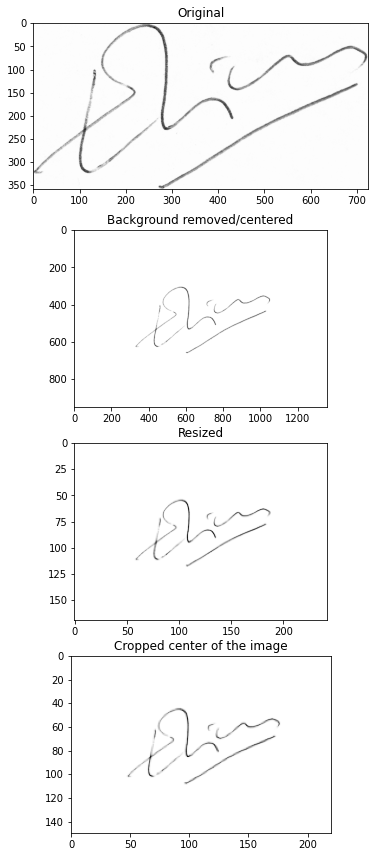

In [19]:
# Visualizing the intermediate steps

f, ax = plt.subplots(4,1, figsize=(6,15))
ax[0].imshow(original, cmap='Greys_r')
ax[1].imshow(normalized)
ax[2].imshow(resized)
ax[3].imshow(cropped)

ax[0].set_title('Original')
ax[1].set_title('Background removed/centered')
ax[2].set_title('Resized')
ax[3].set_title('Cropped center of the image')

## Processing multiple images and obtaining feature vectors

In [20]:
user1_sigs  = [load_signature('data/a{}.png'.format(i)) for i in  [1,2]]
user2_sigs  = [load_signature('data/b{}.png'.format(i)) for i in  [1,2]]

canvas_size = (952, 1360)

processed_user1_sigs = torch.tensor([preprocess_signature(sig, canvas_size) for sig in user1_sigs])
processed_user2_sigs = torch.tensor([preprocess_signature(sig, canvas_size) for sig in user2_sigs])

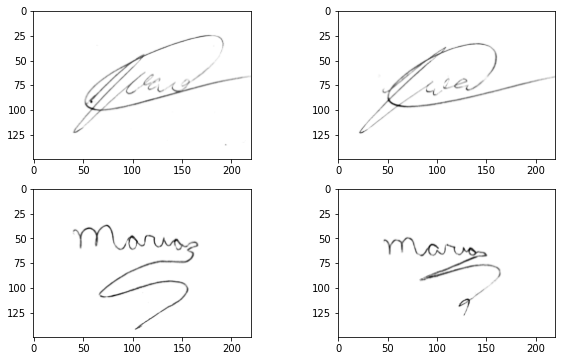

In [21]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,2, figsize=(10,6))
ax[0,0].imshow(processed_user1_sigs[0])
ax[0,1].imshow(processed_user1_sigs[1])

ax[1,0].imshow(processed_user2_sigs[0])
ax[1,1].imshow(processed_user2_sigs[1])

In [22]:
# Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]

processed_user1_sigs = processed_user1_sigs.view(-1, 1, 150, 220).float().div(255)
processed_user2_sigs = processed_user2_sigs.view(-1, 1, 150, 220).float().div(255)

### Using the CNN to obtain the feature representations

In [23]:
# If GPU is available, use it:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cpu


In [24]:
# Load the model
state_dict, _, _ = torch.load('models/signet.pth')
base_model = SigNet().to(device).eval()
base_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
# Obtain the features. Note that you can process multiple images at the same time

with torch.no_grad():
    user1_features = base_model(processed_user1_sigs.to(device))
    user2_features = base_model(processed_user2_sigs.to(device))

### Inspecting the learned features

The feature vectors have size 2048:

In [26]:
user1_features.shape

torch.Size([2, 2048])

In [27]:
print('Euclidean distance between signatures from the same user')
print(torch.norm(user1_features[0] - user1_features[1]))
print(torch.norm(user2_features[0] - user2_features[1]))

Euclidean distance between signatures from the same user
tensor(15.3905)
tensor(15.2066)


In [28]:
print('Euclidean distance between signatures from different users')

dists = [torch.norm(u1 - u2).item() for u1 in user1_features for u2 in user2_features]
print(dists)

Euclidean distance between signatures from different users
[24.94120979309082, 26.872337341308594, 24.501203536987305, 26.877452850341797]


In [29]:
# Other models:
# model_weight_path = 'models/signetf_lambda0.95.pkl'